In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from numpy.linalg import norm

from time import time
from scipy.optimize import minimize
from joblib import Parallel, delayed
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

In [2]:
import numpy as np

def generate_matrices_with_eigenvalue_norm_tolerance(dimension, max_eigenvalue_magnitude):
    """
    Generates two square matrices A and B such that the magnitude of each
    of their eigenvalues is less than a specified 'max_eigenvalue_magnitude'.

    Args:
        dimension (int): The size of the square matrices (e.g., 2 for 2x2).
        max_eigenvalue_magnitude (float): The maximum allowed magnitude (absolute value)
                                          for any eigenvalue of A or B. This is your tolerance.

    Returns:
        tuple: A tuple containing:
            - A (numpy.ndarray): The first generated square matrix.
            - B (numpy.ndarray): The second generated square matrix.
    """
    if max_eigenvalue_magnitude <= 0:
        raise ValueError("max_eigenvalue_magnitude must be a positive number.")

    # 1. Define eigenvalues for A
    # Generate random real eigenvalues, ensuring their magnitude is within the tolerance
    eigenvalues_A = (2 * np.random.rand(dimension) - 1) * max_eigenvalue_magnitude * 0.9 # *0.9 to stay well within bounds

    # 2. Define eigenvalues for B
    eigenvalues_B = (2 * np.random.rand(dimension) - 1) * max_eigenvalue_magnitude * 0.9

    print(f"\nDesired Eigenvalues for A (magnitudes within {max_eigenvalue_magnitude}):\n", eigenvalues_A)
    print(f"Desired Eigenvalues for B (magnitudes within {max_eigenvalue_magnitude}):\n", eigenvalues_B)

    # 3. Create random invertible transformation matrices P and Q
    # These matrices ensure A and B are not just diagonal
    P = np.random.rand(dimension, dimension) * 10 - 5 # Values between -5 and 5
    Q = np.random.rand(dimension, dimension) * 10 - 5

    # Ensure P and Q are invertible
    while np.linalg.det(P) == 0:
        P = np.random.rand(dimension, dimension) * 10 - 5
    while np.linalg.det(Q) == 0:
        Q = np.random.rand(dimension, dimension) * 10 - 5

    # 4. Construct diagonal matrices from the chosen eigenvalues
    D_A = np.diag(eigenvalues_A)
    D_B = np.diag(eigenvalues_B)

    # 5. Generate A and B using similarity transformation: M = P D P_inv
    A = np.linalg.multi_dot([P, D_A, np.linalg.inv(P)])
    B = np.linalg.multi_dot([Q, D_B, np.linalg.inv(Q)])

    # Ensure matrices are purely real (sometimes tiny imaginary parts appear due to floating point)
    A = np.real(A)
    B = np.real(B)

    # --- Verification (Optional, but good for demonstration) ---
    print("\n--- Verification of Eigenvalue Magnitudes ---")
    verified_eigs_A = np.linalg.eigvals(A)
    verified_eigs_B = np.linalg.eigvals(B)

    magnitudes_A = np.abs(verified_eigs_A)
    magnitudes_B = np.abs(verified_eigs_B)

    print(f"Verified Eigenvalue Magnitudes for A:\n {magnitudes_A}")
    print(f"All A magnitudes < {max_eigenvalue_magnitude}: {np.all(magnitudes_A < max_eigenvalue_magnitude)}")
    print(f"Verified Eigenvalue Magnitudes for B:\n {magnitudes_B}")
    print(f"All B magnitudes < {max_eigenvalue_magnitude}: {np.all(magnitudes_B < max_eigenvalue_magnitude)}")

    return A, B

# --- Example Usage ---
# if __name__ == "__main__":
    # User-defined parameters
matrix_dimension = 2
# This is your tolerance: the maximum allowed magnitude for any eigenvalue
tolerance_for_eigenvalue_norm = 0.05

print(f"Generating {matrix_dimension}x{matrix_dimension} matrices with all eigenvalue magnitudes < {tolerance_for_eigenvalue_norm}")

# Generate A and B
A, B = generate_matrices_with_eigenvalue_norm_tolerance(matrix_dimension, tolerance_for_eigenvalue_norm)

print("\nGenerated Matrix A:\n", A)
print("\nGenerated Matrix B:\n", B)

# Now, let's also pick a 'c' (vector or matrix) for demonstration
# You can choose arbitrary x1 and x2 vectors/matrices to form c
print("\n--- Example of choosing 'c' from A, B, x1, x2 ---")
x1_example = np.random.rand(matrix_dimension, 1) * 10 # Random column vector
x2_example = np.random.rand(matrix_dimension, 1) * 10 # Random column vector

print(f"\nExample x1 (random):\n{x1_example}")
print(f"\nExample x2 (random):\n{x2_example}")

c_example = np.dot(A, x1_example) + np.dot(B, x2_example)
print(f"\nResulting c (Ax1 + Bx2):\n{c_example}")

Generating 2x2 matrices with all eigenvalue magnitudes < 0.05

Desired Eigenvalues for A (magnitudes within 0.05):
 [ 0.01104528 -0.03451818]
Desired Eigenvalues for B (magnitudes within 0.05):
 [ 0.03923361 -0.00466437]

--- Verification of Eigenvalue Magnitudes ---
Verified Eigenvalue Magnitudes for A:
 [0.03451818 0.01104528]
All A magnitudes < 0.05: True
Verified Eigenvalue Magnitudes for B:
 [0.00466437 0.03923361]
All B magnitudes < 0.05: True

Generated Matrix A:
 [[-0.03701029 -0.00549977]
 [ 0.02177545  0.01353739]]

Generated Matrix B:
 [[-0.00705467 -0.00304553]
 [ 0.03632946  0.0416239 ]]

--- Example of choosing 'c' from A, B, x1, x2 ---

Example x1 (random):
[[5.10751449]
 [1.24305377]]

Example x2 (random):
[[6.22080242]
 [7.19031443]]

Resulting c (Ax1 + Bx2):
[[-0.26165115]
 [ 0.65333348]]


In [3]:
def f1(x):
    return 0.5*(norm(x)**2)

def grad_f1(x):
    return x

def g1(z):
    return 0.5*(norm(z)**2)
    # return norm(z, ord=1)/3

def grad_g1(z):
    return z

def f2(x):
    return 0.5*(norm(x-2)**2)

def grad_f2(x):
    return x - 2

def g2(z):
    return 0.5*(norm(z-2)**2)
    # return 5*norm(z-2, ord=1)/6

def grad_g2(z):
    return z - 2



# not working
# A = np.array([[1, 0], [0, 1]])
# B = np.array([[1.0, 0.0, 1.0], [0.0, 1.0, 1.0]])
# c = np.array([2.0, 3.0])
# x_dim, z_dim = 2, 3
# m = 2
# bounds = [-2, 2]
# found out by weighted formulation of multiobjective optimization problmes
# true_pareto_front = tpf = np.array([np.array([w**2 - 2*w + 43/16, w**2 + 51/16]) for w in np.linspace(0, 1, 1000)])

# not working
# A = np.eye(3)
# B = np.array([[1,0], [0,1], [1,1]])
# c = np.array([1,1,2])
# x_dim, z_dim = 3, 2
# m = 2
# bounds = [-2, 2]


# working
# A = np.eye(2)
# B = -A.copy()
# c = 0
# bounds = [-2, 2]
# x_dim, z_dim = 2, 2
# m = 2


# m=2
# x_dim, z_dim = 2, 2
# bounds = [-2, 2]
# A = np.array([[2,0], [1,1]])
# B = np.array([[1,0], [1,1]])
# c = np.array([1, 1])


m=2
x_dim, z_dim = 2, 2
bounds = [-5, 5]
# A = np.array([[100,1], [1,100]])
# B = np.array([[-100,-1], [-1,-100]])
# A = np.array([[10, 1], [-5, 9]])/10
# B = np.array([[10, 1], [5, 9]])/10
c = np.array([0, 0])/10


btb_inv = np.linalg.inv(B.T@B)
ata_inv = np.linalg.inv(A.T@A)



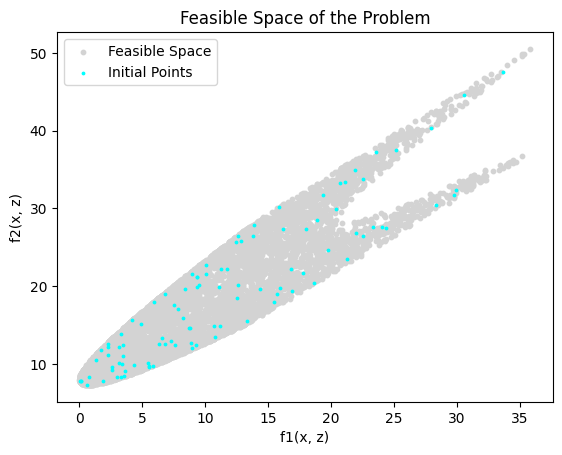

In [4]:
def get_initial_points(n_samples=100):
    initial_x, initial_z = [], []

    while len(initial_x) < n_samples:
        # print(len(initial_x))
        x = np.random.uniform(bounds[0], bounds[1], (x_dim,))
        z = btb_inv @ B.T@(c-A@x)
        if np.all(z >= bounds[0]) and np.all(z <= bounds[1]):
            initial_x.append(x)
            initial_z.append(z)

    return np.array(initial_x), np.array(initial_z)
   
# let us first plot the feasible space of the problem
def plot_feasible_space(tpf=None, initial_values=None, num_feasible_points=50000, plot_lines=True):
    initial_x = np.random.uniform(bounds[0], bounds[1], (num_feasible_points, x_dim))
    values = []
    for x in initial_x:
        z = btb_inv @ B.T@(c-A@x)
        if np.all(z>=bounds[0]) and np.all(z<=bounds[1]):
            values.append(np.array([f1(x) + g1(z), f2(x) + g2(z)]))

    values = np.array(values)
    plt.scatter(values[:, 0], values[:, 1], c='lightgrey', label='Feasible Space', s=10)
    if tpf is not None:
        plt.scatter(tpf[:, 0], tpf[:, 1], facecolor='green',marker='o', s=3, label='Approximate Pareto Front')
    if initial_values is not None:
        plt.scatter(initial_values[:, 0], initial_values[:, 1], s=3, facecolor='cyan', marker='o', label='Initial Points')
    if plot_lines:
        for start, end in zip(initial_values, tpf):
            plt.plot([start[0], end[0]], [start[1], end[1]], color='magenta', linewidth=0.5, alpha=0.6)
            
    plt.xlabel('f1(x, z)')
    plt.ylabel('f2(x, z)')
    plt.title('Feasible Space of the Problem')
    plt.legend()
    plt.show()
        

n_samples = 100
initial_x, initial_z = get_initial_points(n_samples)
initial_values = []
for x, z in zip(initial_x, initial_z):
    initial_values.append(np.array([f1(x) + g1(z), f2(x) + g2(z)]))
initial_values = np.array(initial_values)

# print("DOne")

plot_feasible_space(tpf=None, initial_values=initial_values, plot_lines=False)

In [5]:
max_iters_outer = 200
max_iters_inner = 50
rho = 1.0
beta = 0.5
inner_tol = 1e-6
outer_tol = 1e-6
line_search_tol = 1e-15


In [6]:
def line_search(x_k, z_k, d_x, d_z, line_search_tol=1e-15):
    t = 1.0
    f_curr = np.array([f1(x_k), f2(x_k)])
    g_curr = np.array([g1(z_k), g2(z_k)])

    grad_f = np.array([grad_f1(x_k), grad_f2(x_k)])
    grad_g = np.array([grad_g1(z_k), grad_g2(z_k)])
    
    descent_f = np.array([grad @ d_x for grad in grad_f])
    descent_g = np.array([grad @ d_z for grad in grad_g])
    
    while t > line_search_tol:
        x_new = x_k + t*d_x
        z_new = z_k + t*d_z
        f_new = np.array([f1(x_new), f2(x_new)])
        g_new = np.array([g1(z_new), g2(z_new)])

        # gotta check the bounds also
        
        bounds_check_x = np.all(x_new >= bounds[0]) and np.all(x_new <= bounds[1])
        bounds_check_z = np.all(z_new >= bounds[0]) and np.all(z_new <= bounds[1])
        val_check = np.all(f_new + g_new <= f_curr + g_curr + beta * t * descent_f + beta * t * descent_g)
        # bounds_check = True
        if val_check and bounds_check_x and bounds_check_z:
            return t
        t *= 0.5
    
    if t<= line_search_tol:
        t = 0.0
    print("Line search failed to converge")
    return t

In [7]:
import numpy as np

def solve_x_sub(x_curr, z_curr, d_z, u, Linf=False):
    """
    Solves: min_dx max(x_curr^T dx, (x_curr - 2)^T dx) + (rho/2)*||A dx + B d_z + u||^2
    """
    rhs = B @ d_z + u
    grad1 = x_curr
    grad2 = x_curr - 2

    AtA = rho * A.T @ A
    At_rhs = rho * A.T @ rhs

    # Solve via least squares (robust to singularity)
    dx1, *_ = np.linalg.lstsq(AtA, -grad1 - At_rhs, rcond=None)
    dx2, *_ = np.linalg.lstsq(AtA, -grad2 - At_rhs, rcond=None)

    if Linf:
        dx1 = dx1/ np.linalg.norm(dx1, 1)
        dx2 = dx2/ np.linalg.norm(dx2, 1)

    cond1 = (x_curr @ dx1) - ((x_curr - 2) @ dx1) >= 0
    cond2 = (x_curr @ dx2) - ((x_curr - 2) @ dx2) < 0

    if cond1:
        return dx1
    elif cond2:
        return dx2
    else:
        obj1 = max(x_curr @ dx1, (x_curr - 2) @ dx1) + (rho / 2) * np.linalg.norm(A @ dx1 + rhs)**2
        obj2 = max(x_curr @ dx2, (x_curr - 2) @ dx2) + (rho / 2) * np.linalg.norm(A @ dx2 + rhs)**2
        return dx1 if obj1 <= obj2 else dx2


def solve_z_sub(x_curr, z_curr, d_x, u, Linf=False):
    """
    Solves: min_dz max(z_curr^T dz, (z_curr - 2)^T dz) + (rho/2)*||A d_x + B dz + u||^2
    """
    rhs = A @ d_x + u
    grad1 = z_curr
    grad2 = z_curr - 2

    BtB = rho * B.T @ B
    Bt_rhs = rho * B.T @ rhs

    # Solve via least squares
    dz1, *_ = np.linalg.lstsq(BtB, -grad1 + -Bt_rhs, rcond=None)
    dz2, *_ = np.linalg.lstsq(BtB, -grad2 + -Bt_rhs, rcond=None)

    if Linf:
        dz1 = dz1/ np.linalg.norm(dz1, 1)
        dz2 = dz2/ np.linalg.norm(dz2, 1)

    cond1 = (z_curr @ dz1) - ((z_curr - 2) @ dz1) >= 0
    cond2 = (z_curr @ dz2) - ((z_curr - 2) @ dz2) < 0

    if cond1:
        return dz1
    elif cond2:
        return dz2
    else:
        obj1 = max(z_curr @ dz1, (z_curr - 2) @ dz1) + (rho / 2) * np.linalg.norm(B @ dz1 + rhs)**2
        obj2 = max(z_curr @ dz2, (z_curr - 2) @ dz2) + (rho / 2) * np.linalg.norm(B @ dz2 + rhs)**2
        return dz1 if obj1 <= obj2 else dz2


In [8]:
def find_search_direction(x, z, Linf=False):
    d_x_k, d_z_k, u_k = np.zeros(x_dim), np.zeros(z_dim), np.zeros(x_dim)

    for k in range(max_iters_inner):
        d_x_k_plus_one = solve_x_sub(x, z, d_z_k, u_k, Linf=Linf)
        d_z_k_plus_one = solve_z_sub(x, z, d_x_k_plus_one, u_k, Linf=Linf)
        u_k_plus_one = u_k + (A @ d_x_k_plus_one + B @ d_z_k_plus_one)


        primal_residual = norm(A @ d_x_k_plus_one + B @ d_z_k_plus_one)
        dual_residual = norm(rho*((A.T@B)@(d_z_k_plus_one - d_z_k)))
        # print(f"Inner Iteration {k+1}: Primal Residual = {primal_residual}, Dual Residual = {dual_residual}")

        d_x_k, d_z_k, u_k = d_x_k_plus_one, d_z_k_plus_one, u_k_plus_one

        if primal_residual < inner_tol and dual_residual < inner_tol:
            print(f"SubADMM converged in {k+1} iterations")
            break
    
    return d_x_k, d_z_k
        

In [9]:
M = A @ A.T + B @ B.T  # Matrix in dual space
def project_to_constraint(dx, dz, scale=1):
    """
    Projects (dx, dz) onto the constraint A dx + B dz = 0
    """
    Adx = A @ dx
    Bdz = B @ dz
    
    # Solve for lambda using a stable solve
    rhs = Adx + Bdz
    lam = np.linalg.solve(M, rhs)

    # Compute projections
    dx_proj = dx - scale* A.T @ lam
    dz_proj = dz - scale* B.T @ lam

    return dx_proj, dz_proj


In [10]:

def constr_multiobjective_admm(x_init, z_init, verbose=False, Linf=False):
    table = None
    if verbose:
        table = pd.DataFrame(columns = ['x', 'z', 'dx', 'dz', 't', 'F1', 'F2'])
    
    x, z = x_init.copy(), z_init.copy()
    for i in range(max_iters_outer):
        dx, dz = find_search_direction(x, z)

        # here i must implement a project of dx, dz onto the plane Adx + Bdz = 0
        dx, dz = project_to_constraint(dx, dz)
        

        # line search
        t = line_search(x, z, dx, dz)
        x_new = x + t * dx
        z_new = z + t * dz
        

        if verbose:
            # print(np.round(x_new, 6), np.round(z_new, 6))
            new_df = {
                'x':[np.round(x, 6).tolist()],
                'z':[np.round(z, 6).tolist()],
                'dx':[np.round(dx, 6).tolist()],
                'dz':[np.round(dz, 6).tolist()],
                't':round(t, 6),
                'F1':round(f1(x) + g1(z), 6),
                'F2':round(f2(x) + g2(z), 6)
            }
            # print(new_df)
        
            table = pd.concat([table, pd.DataFrame(new_df, index=[i])], ignore_index=True)
        
        residual = np.sqrt(norm(x_new - x)**2 + norm(z_new - z)**2)
        x, z = x_new, z_new
        if residual < outer_tol:
            print(f"Convergence achieved after {i+1} iterations.")
            break

    if verbose:
        table.to_csv('FUCK_YOU.csv', index=False)
    return x, z

In [11]:
initial_x, initial_z = get_initial_points(100)
converging_points = Parallel(n_jobs=-1)(delayed(constr_multiobjective_admm)(initial_x[i], initial_z[i]) for i in range(len(initial_x)))
# converging_points = constr_multiobjective_admm(initial_x[0], initial_z[0])

Line search failed to converge
Convergence achieved after 1 iterations.
Line search failed to converge
Convergence achieved after 6 iterations.
Line search failed to converge
Convergence achieved after 10 iterations.
Line search failed to converge
Convergence achieved after 8 iterations.
Line search failed to converge
Convergence achieved after 9 iterations.
Line search failed to converge
Convergence achieved after 14 iterations.
Line search failed to converge
Convergence achieved after 10 iterations.
Line search failed to converge
Convergence achieved after 6 iterations.
Line search failed to converge
Convergence achieved after 8 iterations.
Line search failed to converge
Convergence achieved after 5 iterations.
Line search failed to converge
Convergence achieved after 4 iterations.
Line search failed to converge
Convergence achieved after 10 iterations.
Line search failed to converge
Convergence achieved after 6 iterations.
Line search failed to converge
Convergence achieved after 8 

In [12]:
converging_points_values = np.array([np.array([f1(x)+g1(z), f2(x)+g2(z)]) for x, z in converging_points])
initial_point_values = np.array([np.array([f1(x)+g1(z), f2(x)+g2(z)]) for x, z in zip(initial_x, initial_z)])

21


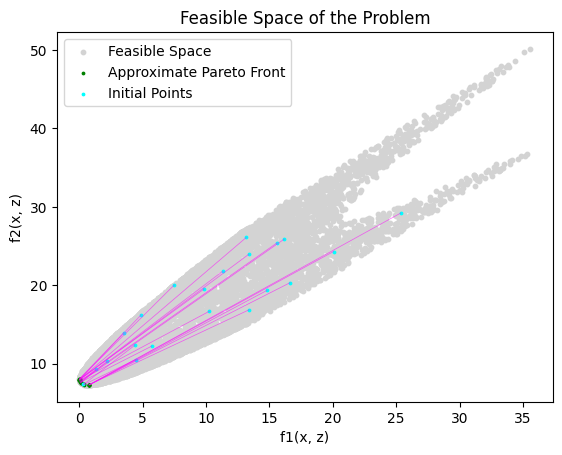

In [15]:
rank = 3
ndps = NonDominatedSorting().do(converging_points_values)
ndps_values, ndps_initial_points_values, ndps_initial_x, ndps_initial_z = [], [], [], []
for i in range(rank):
    ndps_values.append(converging_points_values[ndps[i]])
    ndps_initial_points_values.append(initial_point_values[ndps[i]])
    ndps_initial_x.append(initial_x[ndps[i]])
    ndps_initial_z.append(initial_z[ndps[i]])


ndps_values = np.concatenate(ndps_values)
ndps_initial_points_values = np.concatenate(ndps_initial_points_values)
ndps_initial_x = np.concatenate(ndps_initial_x)
ndps_initial_z = np.concatenate(ndps_initial_z)
print(len(ndps_values))

plot_feasible_space (tpf=ndps_values,initial_values=ndps_initial_points_values)

Line search failed to converge
Convergence achieved after 1 iterations.


/tmp/ipykernel_404187/32740915.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(new_df, index=[i])], ignore_index=True)


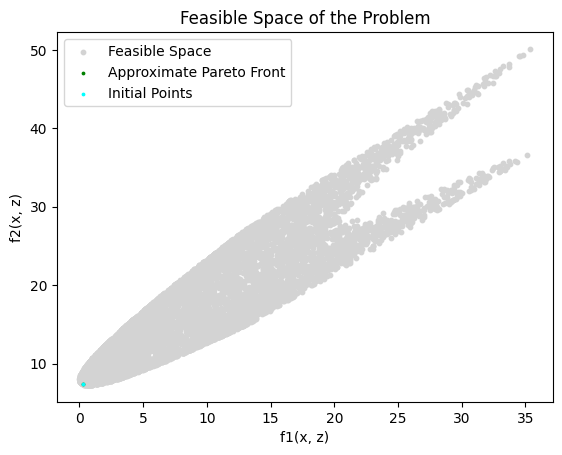

In [19]:
# import warnings
# warnings.filterwarnings("ignore")
# for i in range(len(ndps_initial_x)):
#     print(f'-----------------------Iteration = {i}----------------------------')
#     constr_multiobjective_admm(ndps_initial_x[i], ndps_initial_z[i], verbose=True, Linf=True)


i=0
constr_multiobjective_admm(ndps_initial_x[i], ndps_initial_z[i], verbose=True, Linf=False)
plot_feasible_space(tpf=ndps_values[i:i+1], 
                    initial_values=ndps_initial_points_values[i:i+1])


# constr_multiobjective_admm(initial_x[i], initial_z[i], verbose=True, Linf=True)
# plot_feasible_space(tpf=converging_points_values[i:i+1], 
#                     initial_values=initial_point_values[i:i+1])

In [61]:

# plot_feasible_space(tpf=converging_points_values, 
#                     initial_values=initial_point_values)

100


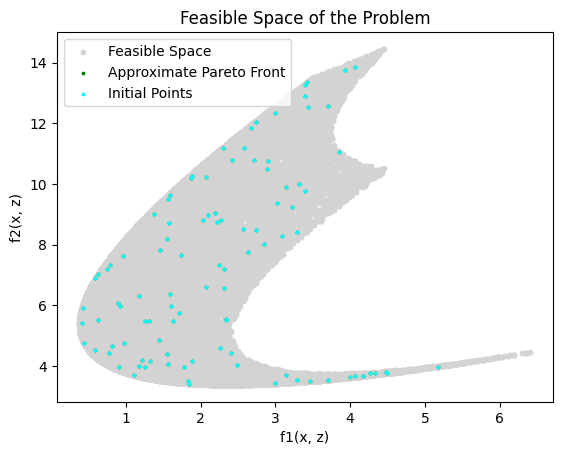